In [147]:
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm, inv
from scipy.stats import unitary_group

In [148]:
def xx_to_xp(S, r):
    """
    Converts S and r from non-interleaved (x1...xm, p1...pm) 
    to interleaved (x1, p1, ..., xm, pm) ordering.
    """
    dim = S.shape[0]
    m = dim // 2
    
    # 1. Create the permutation index array
    # This creates: [0, m, 1, m+1, 2, m+2, ..., m-1, 2m-1]
    perm = np.empty(dim, dtype=int)
    perm[0::2] = np.arange(m)      # Even indices get the first m elements (x)
    perm[1::2] = np.arange(m, dim) # Odd indices get the last m elements (p)
    
    # 2. Permute the displacement vector r
    r_xp = r[perm]
    
    # 3. Permute the symplectic matrix S
    # We must apply the permutation to both rows and columns
    S_xp = S[perm, :][:, perm]
    
    return S_xp, r_xp

def omega_mat(m):
    """
    Creates the 2m x 2m canonical symplectic form Omega for m modes.
    Uses the interleaved ordering: (x1, p1, x2, p2, ..., xm, pm).
    
    Args:
        m (int): The number of modes.
        
    Returns:
        np.ndarray: A 2m x 2m anti-symmetric real matrix.
    """
    # Create a 2x2 fundamental symplectic block
    omega_1 = np.array([[0, 1], 
                        [-1, 0]])
    
    # Use np.kron (Kronecker product) to repeat the block m times along the diagonal
    # This is equivalent to a block_diag operation.
    return np.kron(np.eye(m), omega_1)

# Gaussian State

In [149]:
class GaussianState:
    """
    Represents an m-mode Gaussian state. [cite: 239]
    
    Attributes:
        m (int): The number of modes. [cite: 237, 238]
        mean (np.ndarray): First-moment vector in R^{2m}. 
        cov (np.ndarray): Covariance matrix in R^{2m x 2m}. 
    """
    def __init__(self, mean, cov):
        # Ensure the mean is a 1D array and the covariance is a 2D array
        self.mean = np.array(mean, dtype=np.float64).flatten()
        self.cov = np.array(cov, dtype=np.float64)
        
        # Determine dimension and number of modes
        # The phase space dimension is 2m [cite: 242, 247]
        self.dim = len(self.mean)
        if self.dim % 2 != 0:
            raise ValueError("The mean vector must have an even dimension (2m).")
            
        if self.cov.shape != (self.dim, self.dim):
            raise ValueError(f"Covariance matrix must be {self.dim}x{self.dim}.")
            
        self.m = self.dim // 2 

    def __repr__(self):
        return f"GaussianState(modes={self.m}, mean_norm={self.mean})"

    @classmethod
    def coherent(cls, m_modes, mean_vector=None):
        """
        Creates an m-mode coherent state.
        
        Args:
            m_modes (int): Number of modes for the state 
            mean_vector (np.ndarray, optional): A 2m-dimensional vector 
                representing the displacement (x1, p1, ..., xm, pm). 
                If None, creates a vacuum state.
        """
        dim = 2 * m_modes
        
        # If no mean vector is provided, default to the vacuum state (zero mean) 
        if mean_vector is None:
            mean = np.zeros(dim)
        else:
            mean = np.array(mean_vector, dtype=np.float64)
            if len(mean) != dim:
                raise ValueError(f"Mean vector must have length {dim} for {m_modes} modes.")
        
        # Coherent states always have a covariance matrix equal to the identity 
        cov = np.eye(dim)
        
        return cls(mean, cov)
        
    def mean_photon_number(self):
        """
        Computes the mean photon number (energy) of the Gaussian state.
        Based on Eq. (2.23) from the paper.
        """
        # Term 1: (Tr(V) - Tr(I)) / 4
        # Note: Tr(I) for a 2m x 2m matrix is simply the dimension (2m)
        trace_term = (np.trace(self.cov) - self.dim) / 4.0
        
        # Term 2: ||m||^2 / 2
        # This is the squared Euclidean norm of the mean vector divided by 2
        displacement_term = np.linalg.norm(self.mean)**2 / 2.0
        
        return trace_term + displacement_term

    def measure_heterodyne(self, num_meas=1):
        """
        Simulates heterodyne measurement on the Gaussian state.
        
        Args:
            num_meas (int): The number of independent measurement samples to generate.
            
        Returns:
            np.ndarray: An array of shape (num_meas, 2m) containing the classical 
                        outcomes for each measurement.
        """
        # Define the heterodyne covariance matrix: (V + I) / 2
        het_cov = (self.cov + np.eye(self.dim)) / 2.0
        
        # Generate num_meas samples from the multivariate normal distribution
        # defined by the state's mean and the heterodyne covariance.
        samples = np.random.multivariate_normal(
            mean=self.mean, 
            cov=het_cov, 
            size=num_meas
        )
        
        return samples

    def is_valid(self, tol=1e-9):
        """
        Checks if the Gaussian state satisfies the Heisenberg uncertainty principle.
        Condition: V + i*Omega >= 0
        """
        # 1. Get the canonical symplectic form for the state's modes
        # Use the utility function: omega(m)
        Omega = omega_mat(self.m)
        
        # 2. Construct the uncertainty matrix: M = V + i*Omega
        # V must be real and symmetric, Omega is anti-symmetric
        #
        uncertainty_matrix = self.cov.astype(complex) + 1j * Omega
        
        # 3. Check if the matrix is positive semi-definite
        # We compute the eigenvalues of the Hermitian matrix
        eigenvalues = np.linalg.eigvalsh(uncertainty_matrix)
        
        # Every eigenvalue must be non-negative (within numerical tolerance)
        return bool(np.all(eigenvalues >= -tol))

    def is_pure(self, tol=1e-7):
        """
        Checks if the Gaussian state is a pure state.
        A Gaussian state is pure if and only if det(V) = 1.
        
        Returns:
            bool: True if pure, False if mixed.
        """
        # 1. Calculate the determinant of the covariance matrix
        # For a physically valid state, det(V) >= 1 always.
        det_v = np.linalg.det(self.cov)
        
        # 2. Check if the determinant is 1 within numerical tolerance
        # Purity gamma = 1 / sqrt(det_v)
        return bool(np.isclose(det_v, 1.0, atol=tol))

# Gaussian Unitary

In [150]:
class GaussianUnitary:
    """
    Represents a bosonic Gaussian unitary G = Dr * Us.
    
    Attributes:
        m (int): Number of modes.
        dim (int): Phase-space dimension (2 * m).
        S (np.ndarray): 2m x 2m real symplectic matrix.
        r (np.ndarray): 2m-dimensional real displacement vector.
    """
    def __init__(self, S, r):
        # The phase-space dimension is determined by the size of the symplectic matrix 
        self.dim = S.shape[0]
        
        # Verify that the matrix is square and the displacement vector matches its size
        if S.shape[0] != S.shape[1]:
            raise ValueError("Symplectic matrix S must be square.")
        if len(r) != self.dim:
            raise ValueError(f"Displacement vector r must have dimension {self.dim}.")
        if self.dim % 2 != 0:
            raise ValueError("Phase-space dimension must be even (2 * m).")
            
        self.S = np.array(S, dtype=np.float64)
        self.r = np.array(r, dtype=np.float64)
        self.m = self.dim // 2
        self.z = np.linalg.norm(S, ord=np.inf)

    def __repr__(self):
        return f"GaussianUnitary(modes={self.m}, dim={self.dim})\n\nS = {self.S}\n\nr = {self.r}"

    def is_symplectic(self, tol=1e-9):
        """
        Checks if the stored matrix S is actually symplectic.
        
        Args:
            tol (float): Numerical tolerance for the comparison.
            
        Returns:
            bool: True if S is symplectic, False otherwise.
        """
        # 1. Construct the canonical symplectic form Omega
        # Omega = \bigoplus_{i=1}^{m} [[0, 1], [-1, 0]]
        Omega = omega_mat(self.m)
            
        # 2. Check the condition: S^T @ Omega @ S == Omega
        # We use np.allclose for numerical stability
        left_side = self.S.T @ Omega @ self.S
        print("Symplectic relationship: ", np.linalg.norm(left_side - Omega, ord=np.inf))
        return np.allclose(left_side, Omega, atol=tol)
    
    @classmethod
    def random(cls, m, z):
        """
        Constructs a random Gaussian Unitary using Bloch-Messiah decomposition.
        S = O1 * Zs * O2 in interleaved (x1, p1, x2, p2...) ordering.
        """
        def get_random_orthogonal_symplectic(m_modes):
            """
            Creates a random passive transformation by embedding a Haar-random 
            complex unitary U = X + iY into a 2m x 2m real matrix.
            """
            # Sample a Haar-random complex unitary matrix
            U = unitary_group.rvs(m_modes)
            X = U.real
            Y = U.imag
            
            # Create the 2m x 2m interleaved matrix
            # For each mode pair, the complex multiplication (X+iY)(x+ip) 
            # maps to [[X, -Y], [Y, X]] in the real xp-space.
            O = np.zeros((2 * m_modes, 2 * m_modes))
            for i in range(m_modes):
                for j in range(m_modes):
                    # Setting the 2x2 blocks for interleaved ordering
                    block = np.array([[X[i, j], -Y[i, j]],
                                      [Y[i, j],  X[i, j]]])
                    O[2*i:2*i+2, 2*j:2*j+2] = block
            return O

        # 1. Generate two random passive interferometers O1 and O2
        O1 = get_random_orthogonal_symplectic(m)
        O2 = get_random_orthogonal_symplectic(m)
        
        # 2. Generate squeezing parameters z_j such that 1 <= z_j <= z
        # We set the first one to exactly z to saturate the bound ||S||_inf = z
        z_vals = np.random.uniform(1.0, z, m)
        z_vals[0] = z
        
        # 3. Construct the diagonal squeezing matrix Zs (interleaved)
        # Zs = diag(z1, 1/z1, z2, 1/z2, ...)
        Zs = np.zeros((2 * m, 2 * m))
        for j in range(m):
            Zs[2*j, 2*j] = z_vals[j]
            Zs[2*j+1, 2*j+1] = 1.0 / z_vals[j]
            
        # 4. Compose the full symplectic matrix S = O1 @ Zs @ O2
        # This satisfies S^T Omega S = Omega in xp-ordering [cite: 332]
        S_paper = O1 @ Zs @ O2
        
        # 5. Generate random displacement r in R^{2m}
        r_paper = np.random.normal(0, 1, 2 * m)
        
        return cls(S_paper, r_paper)

    def evolve(self, state):
        """
        Applies this Gaussian unitary to a GaussianState object.
        Returns a new GaussianState with updated mean and covariance.
        """
        if state.m != self.m:
            raise ValueError(f"State modes ({state.m}) must match unitary modes ({self.m}).")

        # 1. Update the first moment (mean): m' = Sm + r
        # Based on Eq. (2.9) and (2.11) in the paper
        new_mean = self.S @ state.mean + self.r

        # 2. Update the second moment (covariance): V' = S V S^T
        # Based on Eq. (2.10) and (2.12) in the paper
        new_cov = self.S @ state.cov @ self.S.T

        return GaussianState(new_mean, new_cov)

    def estimate_displacement(self, num_meas):
        """
        Estimates the displacement vector r of the unknown unitary 
        using vacuum probes and heterodyne detection.
        
        Based on Section 4.1 (Vacuum-shared inputs) of the paper.
        """
        # 1. Prepare an m-mode vacuum state (a coherent state with zero mean)
        vacuum_probe = GaussianState.coherent(self.m, mean_vector=None)
        
        # 2. Apply the unknown unitary (self) to the vacuum probe
        # The output state mean will be centered at the displacement vector r
        output_state = self.evolve(vacuum_probe)
        
        # 3. Perform num_meas heterodyne measurements
        # Outcomes are distributed as N(r, (SS^T + I)/2)
        measurements = output_state.measure_heterodyne(num_meas=num_meas)
        
        # 4. Calculate the empirical mean to estimate r
        # As per Algorithm 1, Step 3 and Lemma 4.1
        r_estimate = np.mean(measurements, axis=0)
        
        return r_estimate

    def estimate_symplectic(self, displacement_est, meas_per_col, eta=1.0):
        """
        Estimates the symplectic matrix S using the vacuum-shared input protocol.
        
        Args:
            displacement_est (np.ndarray): The average heterodyne outcome from 
                the vacuum probe (the result of estimate_displacement).
            meas_per_col (int): Number of heterodyne shots per basis vector (Ns).
            eta (float): The probe amplitude for the coherent states.
            
        Returns:
            np.ndarray: A 2m x 2m estimate of the symplectic matrix S.
        """
        # Initialize an empty matrix for the estimate S_hat
        # The dimension is 2m x 2m 
        S_hat = np.zeros((self.dim, self.dim))
        
        # Iterate through each column of the phase space (2m columns)
        for i in range(self.dim):
            # 1. Create a "one-hot" mean vector: eta * e_i [cite: 478]
            one_hot_mean = np.zeros(self.dim)
            one_hot_mean[i] = eta
            
            # 2. Prepare the coherent probe state |eta * e_i> 
            probe_state = GaussianState.coherent(self.m, mean_vector=one_hot_mean)
            
            # 3. Apply the unknown unitary to the probe 
            transformed_state = self.evolve(probe_state)
            
            # 4. Perform heterodyne detection to get Y_i
            measurements = transformed_state.measure_heterodyne(num_meas=meas_per_col)
            Y_i_bar = np.mean(measurements, axis=0)
            
            # 5. Construct the i-th column estimator
            # S_hat_i = (Y_i_bar - displacement_baseline) / eta
            S_hat[:, i] = (Y_i_bar - displacement_est) / eta
            
        return S_hat

    def estimate_unitary(self, num_meas):
        """
        Estimate displacement and symplectic components of unitary using previous methods
        """

        r_hat = self.estimate_displacement(num_meas)
        S_hat = self.estimate_symplectic(r_hat, num_meas)

        return GaussianUnitary(S_hat, r_hat)

    def regularize(self):
        """
        Enforces exact symplecticity on the current S matrix and returns 
        a new regularized GaussianUnitary object.
        
        Based on Section 4.3: Symplectic Regularization.
        """
        # 1. Construct the canonical symplectic form Omega for m modes
        # Omega = block_diag([[0, 1], [-1, 0]], ..., [[0, 1], [-1, 0]])
        Omega = omega_mat(self.m)
            
        # 2. Compute T = -Omega @ S^T @ Omega @ S
        # If the matrix is already symplectic, T will be the identity.
        T = -Omega @ self.S.T @ Omega @ self.S
        
        # 3. Compute the principal square root Q = sqrt(T)
        # The paper notes this exists if S_est is sufficiently close to S.
        Q = sqrtm(T)
        
        # Numerical safety: ensure Q is real
        if np.iscomplexobj(Q):
            Q = Q.real
            
        # 4. Compute S_tilde = Q^-1 @ S
        # This matrix S_tilde is guaranteed to be symplectic.
        S_tilde = self.S @ inv(Q)   
        # print(np.linalg.norm(inv(Q) @ self.S - self.S @inv(Q), ord=np.inf))
        
        # Return a new GaussianUnitary object with the regularized S and original r
        return GaussianUnitary(S_tilde, self.r)

# Gaussian Process

In [151]:
import numpy as np

class GaussianProcess:
    """
    Represents a general m-mode Gaussian channel (potentially non-unitary).
    A channel is defined by the transformation:
    m -> Xm + d
    V -> XVX^T + Y
    """
    def __init__(self, X, Y, d):
        """
        Initialize the Gaussian Process.
        
        Args:
            X (np.ndarray): 2m x 2m transmission matrix. [cite: 62]
            Y (np.ndarray): 2m x 2m symmetric noise matrix. 
            d (np.ndarray): 2m-dimensional displacement vector. [cite: 61, 93]
        """
        self.dim = X.shape[0]
        if self.dim % 2 != 0:
            raise ValueError("Phase-space dimension must be even (2m).")
        
        if X.shape != (self.dim, self.dim):
            raise ValueError(f"X must be {self.dim}x{self.dim}.")
        if Y.shape != (self.dim, self.dim):
            raise ValueError(f"Y must be {self.dim}x{self.dim}.")
        if len(d) != self.dim:
            raise ValueError(f"Displacement d must have length {self.dim}.") 
            
        self.X = np.array(X, dtype=np.float64)
        self.Y = np.array(Y, dtype=np.float64)
        self.d = np.array(d, dtype=np.float64)
        self.m = self.dim // 2 

    def __repr__(self):
        return f"GaussianProcess(modes={self.m}, type='General Channel') \n\nX = {self.X}\n\nY = {self.Y}"

    @classmethod
    def from_unitary(cls, G, m_sys):
        """
        Constructs a GaussianProcess from a GaussianUnitary dilation.
        Assumes the environment (modes k = G.m - m_sys) is in the vacuum state.
        
        Args:
            G (GaussianUnitary): The global unitary acting on system + environment.
            m_sys (int): Number of modes belonging to the system.
        """
        # Determine the phase-space dimension of the system
        dim_sys = 2 * m_sys
        
        if dim_sys > G.dim:
            raise ValueError("m_sys cannot be greater than the total modes in G.")

        # 1. Extract the Transmission Matrix X (S_sys,sys)
        # This is the top-left block of G.S [cite: 1375, 1378]
        X = G.S[:dim_sys, :dim_sys]

        # 2. Extract the Environment Coupling (S_sys,env)
        # This is the top-right block of G.S [cite: 1375, 1380]
        S_env = G.S[:dim_sys, dim_sys:]

        # 3. Compute the Noise Matrix Y
        # For environment vacuum V_env = I, Y = S_env @ S_env.T 
        Y = S_env @ S_env.T

        # 4. Extract the system Displacement d
        # This is the first 2*m_sys elements of G.r 
        d = G.r[:dim_sys]

        return cls(X, Y, d)

    @classmethod
    def random(cls, m, z):
        """
        Generates a random m-mode Gaussian process via a 3m-mode unitary dilation.
        
        Args:
            m (int): Number of system modes.
            z (float): Squeezing bound for the global dilation unitary.
        """
        # 1. Generate a random Gaussian unitary on 3m modes
        # Based on the dilation limit: system (m) + environment (2m)
        total_modes = 3 * m
        global_unitary = GaussianUnitary.random(total_modes, z)
        
        # 2. Convert the global unitary to a GaussianProcess
        # This uses the from_unitary method to trace out the 2m environment modes
        return cls.from_unitary(global_unitary, m_sys=m)

    def is_cp(self, tol=1e-9):
        """
        Checks if the Gaussian process is completely positive (physically valid).
        Condition: Y + i*Omega - i*X*Omega*X^T >= 0
        """
        # 1. Construct the interleaved symplectic form Omega (2m x 2m)
        Omega = omega_mat(self.m)
            
        # 2. Compute the CP matrix: M = Y + i*Omega - i*X*Omega*X^T
        # Note: '1j' is the imaginary unit in Python
        #
        X_Omega_XT = self.X @ Omega @ self.X.T
        cp_matrix = self.Y.astype(complex) + 1j * Omega - 1j * X_Omega_XT
        
        # 3. Check for Positive Semi-Definiteness
        # Since the matrix is Hermitian by construction, we use eigvalsh
        # which is optimized for symmetric/Hermitian matrices.
        eigenvalues = np.linalg.eigvalsh(cp_matrix)
        
        # All eigenvalues must be >= 0 (within numerical tolerance)
        # print(eigenvalues)
        return bool(np.all(eigenvalues >= -tol))

    def evolve(self, state):
        """
        Transforms a GaussianState through the Gaussian channel.
        
        Args:
            state (GaussianState): The input state to be evolved.
            
        Returns:
            GaussianState: The resulting state after the process.
        """
        if state.m != self.m:
            raise ValueError(
                f"State modes ({state.m}) must match process modes ({self.m})."
            )

        # 1. Update the mean (first moment): m' = Xm + d
        new_mean = self.X @ state.mean + self.d

        # 2. Update the covariance (second moment): V' = XVX^T + Y
        new_cov = self.X @ state.cov @ self.X.T + self.Y

        # Return a new GaussianState instance
        return GaussianState(new_mean, new_cov)


    def estimate_disp_cov(self, num_meas):
        """
        Estimates the displacement vector d and the output covariance matrix 
        using vacuum probes.
        
        Returns:
            d_hat (np.ndarray): Empirical mean (2m,)
            V_out_hat (np.ndarray): Estimated output covariance matrix (2m, 2m)
        """
        # 1. Prepare an m-mode vacuum state (mean=0, cov=I)
        vacuum_probe = GaussianState.coherent(self.m, mean_vector=None)
        
        # 2. Evolve through the process
        output_state = self.evolve(vacuum_probe)
        
        # 3. Perform heterodyne measurements
        # samples shape: (num_meas, 2m)
        samples = output_state.measure_heterodyne(num_meas=num_meas)
        
        # 4. Compute empirical mean (d_hat)
        d_hat = np.mean(samples, axis=0)
        
        # 5. Compute the classical covariance of the heterodyne outcomes
        # rowvar=False because each row is a sample
        V_het_hat = np.cov(samples, rowvar=False)
        
        # 6. Back-calculate the quantum covariance V_out
        # Since V_het = (V_out + I) / 2  =>  V_out = 2 * V_het - I
        V_out_hat = 2 * V_het_hat - np.eye(self.dim)
        
        return d_hat, V_out_hat

    def estimate_X(self, displacement_est, meas_per_col, eta=1.0):
        """
        Estimates the transmission matrix X of the Gaussian process.
        
        Args:
            displacement_est (np.ndarray): The estimated displacement vector d 
                (obtained from estimate_displacement).
            meas_per_col (int): Number of heterodyne shots for each basis vector.
            eta (float): The probe amplitude for the coherent states.
            
        Returns:
            np.ndarray: A 2m x 2m estimate of the transmission matrix X.
        """
        # Initialize an empty matrix for the estimate X_hat
        X_hat = np.zeros((self.dim, self.dim))
        
        for i in range(self.dim):
            # 1. Create a "one-hot" mean vector: eta * e_i
            one_hot_mean = np.zeros(self.dim)
            one_hot_mean[i] = eta
            
            # 2. Prepare the coherent probe state |eta * e_i>
            probe_state = GaussianState.coherent(self.m, mean_vector=one_hot_mean)
            
            # 3. Evolve the probe through the process
            # The mean of this state is centered at X * (eta * e_i) + d
            output_state = self.evolve(probe_state)
            
            # 4. Perform heterodyne detection to get average outcome Y_i_bar
            measurements = output_state.measure_heterodyne(num_meas=meas_per_col)
            Y_i_bar = np.mean(measurements, axis=0)
            
            # 5. Extract the i-th column of X
            # X_hat_i = (average_outcome - d_est) / eta
            X_hat[:, i] = (Y_i_bar - displacement_est) / eta
            
        return X_hat

    def estimate_process(self, num_meas):
        """
        Performs full tomography of the Gaussian process.
        
        Args:
            num_meas (int): Number of measurement shots used for EACH estimation step.
            
        Returns:
            X_hat (np.ndarray): Estimated transmission matrix.
            Y_hat (np.ndarray): Estimated noise matrix.
            d_hat (np.ndarray): Estimated displacement vector.
        """
        # 1. Step 1: Estimate displacement (d) and output covariance (V_out)
        # We use vacuum probes for this stage.
        # V_out = X * I * X^T + Y = XX^T + Y
        d_hat, V_out_hat = self.estimate_disp_cov(num_meas)
        
        # 2. Step 2: Estimate the Transmission Matrix (X)
        # We use coherent probes |eta * e_i>. 
        # Using eta=1.0 for simplicity, though higher values can improve SNR.
        X_hat = self.estimate_X(displacement_est=d_hat, meas_per_col=num_meas, eta=1.0)
        
        # 3. Step 3: Solve for the Additive Noise Matrix (Y)
        # Since V_out = X * X^T + Y, then Y = V_out - X * X^T
        Y_hat = V_out_hat - (X_hat @ X_hat.T)
        
        return GaussianProcess(X_hat, Y_hat, d_hat)
    
    def X_dist(self, GP, order = np.inf):
        return np.linalg.norm(self.X - GP.X, ord=order)

    def Y_dist(self, GP, order = np.inf):
        return np.linalg.norm(self.Y - GP.Y, ord= order)

    def regularize_Y(self):
        """
        Regularizes the noise matrix Y to be positive semi-definite (PSD).
        Sets all negative eigenvalues of Y to zero.
        
        Returns:
            np.ndarray: The regularized, PSD noise matrix Y_tilde.
        """
        # 1. Perform eigenvalue decomposition for a symmetric matrix
        # eigenvalues (w) are sorted in ascending order; vectors (v) are columns
        w, v = np.linalg.eigh(self.Y)
        
        # 2. Clip negative eigenvalues to zero
        # We use a small epsilon or strictly zero
        w_clipped = np.maximum(w, 0)
        
        # 3. Reconstruct the matrix Y_tilde = V * diag(w_clipped) * V^T
        # This is the projection onto the PSD cone in the Frobenius norm sense
        Y_tilde = v @ np.diag(w_clipped) @ v.T
        
        # Update the internal state
        self.Y = Y_tilde
        
        return Y_tilde

# Benchmarking Mele Algorithm

In [12]:
def error_vs_meas(G, meas_arr, num_trials, randomize_unitary= False):
    """
    Analyzes the scaling of symplectic estimation error vs measurement count
    with error bars representing the standard deviation across trials.
    """
    raw_errors = np.zeros((len(meas_arr), num_trials))
    reg_errors = np.zeros((len(meas_arr), num_trials))
    
    for i, num_meas in enumerate(meas_arr):
        for trial in range(num_trials):

            if randomize_unitary: 
                m = G.m
                z = G.z
                G = GaussianUnitary.random(m, z) 
                
            # 1. Estimate displacement baseline (vacuum probe)
            # This is Step 3 in Algorithm 1 [cite: 1075]
            r_hat = G.estimate_displacement(num_meas)
            
            # 2. Estimate S_hat using coherent probes |eta e_i>
            # This is Step 4-6 in Algorithm 1 [cite: 1075]
            S_hat = G.estimate_symplectic(displacement_est=r_hat, meas_per_col=num_meas)
            
            # 3. Raw error calculation (operator norm error [cite: 95])
            raw_err = np.linalg.norm(S_hat - G.S, ord=np.inf)
            raw_errors[i, trial] = raw_err
            
            # 4. Symplectic Regularization (Algorithm 1, Step 7 [cite: 1075])
            # Uses the matrix square root correction Q [cite: 119, 120]
            G_temp = GaussianUnitary(S_hat, r_hat)
            G_reg = G_temp.regularize()
            
            # 5. Regularized error calculation
            reg_err = np.linalg.norm(G_reg.S - G.S, ord=np.inf)
            reg_errors[i, trial] = reg_err
            
    # Calculate means and standard deviations
    mean_raw = np.mean(raw_errors, axis=1)
    std_raw = np.std(raw_errors, axis=1)/np.sqrt(num_trials)
    
    mean_reg = np.mean(reg_errors, axis=1)
    std_reg = np.std(reg_errors, axis=1)/np.sqrt(num_trials)
    
    # Generate the log-log plot with error bars
    plt.figure(figsize=(10, 7))
    
    # Plotting raw errors
    plt.errorbar(meas_arr, mean_raw, yerr=std_raw, fmt='o-', capsize=5, 
                 label='Empirical Estimate ($\hat{S}$)', alpha=0.8)
    
    # Plotting regularized errors
    plt.errorbar(meas_arr, mean_reg, yerr=std_reg, fmt='s--', capsize=5, 
                 label='Regularized Estimate ($\\tilde{S}$)', alpha=0.8)
    
    # Reference line for 1/sqrt(N) scaling [cite: 111, 211]
    plt.loglog(meas_arr, mean_raw[0] * np.sqrt(meas_arr[0]/meas_arr), 
               'k:', alpha=0.5, label='Theoretical $1/\sqrt{N_S}$ scaling')

    # Mele regularized error bound -- if raw estimate has error epsilon, then regularized should have error epsilon*9*z**2
    # plt.loglog(meas_arr, mean_raw * 9 * G.z**2, 'k:', alpha=0.5, label='Theoretical $1/\sqrt{N_S}$ scaling')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Measurements per Probe ($N_S$)')
    plt.ylabel('Infinity Norm Error ($||S_{est} - S||_{\infty}$)')
    plt.title('Symplectic Learning Error: Scaling and Variance')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()

    return raw_errors, reg_errors

In [13]:
# Example usage:
# m = 3 modes, squeezing bound z = 2.0
z = 2
G = GaussianUnitary.random(2, z)

print(f"Symplectic Matrix S (shape {G.S.shape}):\n{G.S}")
print(f"\nDisplacement Vector r:\n{G.r}")
np.linalg.norm(G.S, ord=np.inf)

Symplectic Matrix S (shape (4, 4)):
[[ 2.27822930e-01  1.36019121e-01  4.57223201e-01 -5.57013686e-01]
 [-9.98131322e-01  3.59726399e-01  1.14665762e-01  1.57124733e+00]
 [-5.99292285e-05  5.60838952e-01 -3.45900643e-01  1.41924703e-01]
 [-1.39485141e+00  9.79242551e-02  2.05061464e-01 -7.13563735e-01]]

Displacement Vector r:
[-0.05062091  0.34558268  0.65091704  1.38489282]


np.float64(3.0437708140547164)

In [14]:
G_est = G.estimate_unitary(10**2)
print(np.linalg.eig(G_est.S)[0])
G_est.regularize().is_symplectic()

[ 0.52980717+0.76173367j  0.52980717-0.76173367j -1.1572641 +0.07150699j
 -1.1572641 -0.07150699j]
Symplectic relationship:  1.6002824065886045e-15


True

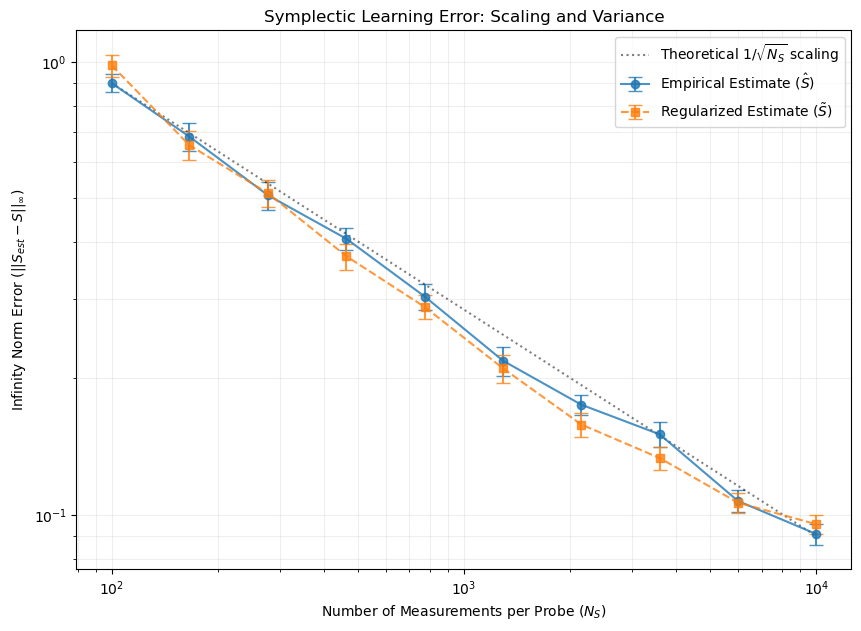

(array([[1.13372809, 0.68035992, 1.1523441 , 0.62770535, 0.71848314,
         1.09783569, 0.9527195 , 0.83596812, 0.82644581, 0.68839123,
         0.92593012, 1.43846774, 0.66001704, 0.56279502, 0.76199269,
         0.88410935, 0.75174338, 1.06437079, 1.3641453 , 0.97030502,
         1.2746061 , 0.67264336, 0.99027593, 0.53569501, 0.97677086,
         0.88620724, 0.78917672, 0.70009785, 0.6812899 , 0.84948184,
         1.67924697, 0.65248941, 1.51526173, 0.7978753 , 1.04163607,
         0.85384509, 0.69450507, 0.75379306, 0.7596335 , 0.69180533],
        [0.7176953 , 0.87109116, 0.50588278, 0.72222295, 0.4324165 ,
         0.5519456 , 0.88246887, 0.43227867, 1.76192714, 0.73853332,
         0.80398625, 0.52664085, 0.43019775, 0.46666114, 0.36072782,
         0.36252747, 0.89394274, 0.39770182, 0.8242017 , 0.67273745,
         0.37789154, 1.00991125, 0.59498416, 0.48739878, 0.41900933,
         0.90734678, 0.47843778, 0.4771136 , 1.06295078, 0.60083731,
         0.32284595, 1.01558036, 

In [18]:
meas_arr = np.logspace(2,4,10).astype(int)
error_vs_meas(G, meas_arr, 40, randomize_unitary = False)


In [11]:
G_est = G.estimate_unitary(10**4)
print(G_est)
print()
print("Inf norm = ", np.linalg.norm(G_est.S - G.S, ord=np.inf), "\n")
G_reg = G_est.regularize()
print(G_reg)
print("Inf norm = ", np.linalg.norm(G_reg.S - G.S, ord=np.inf), "\n")

GaussianUnitary(modes=2, dim=4)

S = [[ 0.34227995  0.79305763  0.84645372 -0.2854245 ]
 [-0.38563158 -1.00292505  0.332252    1.14536079]
 [ 0.29193665  0.9118221  -0.06637526 -0.07507975]
 [-1.09719326  0.07447135 -1.20747791 -0.67057934]]

r = [-0.42903168  0.10477807  1.11246548  0.54430067]

Inf norm =  0.08428554848431087 

GaussianUnitary(modes=2, dim=4)

S = [[ 0.34122235  0.79005267  0.83585199 -0.28162536]
 [-0.3808044  -1.00407391  0.33355712  1.13395528]
 [ 0.29378239  0.91884886 -0.0701392  -0.07378726]
 [-1.10839272  0.07934968 -1.20623798 -0.67363278]]

r = [-0.42903168  0.10477807  1.11246548  0.54430067]
Inf norm =  0.0761509011616632 



# Gaussian Processes

In [143]:
m = 2
z = 6
state = GaussianState.coherent(m)
GP = GaussianProcess.random(m,z)

In [144]:
GP_est = GP.estimate_process(10**2)

In [139]:
GP_est.Y = GP_est.regularize_Y()
vals, _ = np.linalg.eig(GP_est.Y)
vals

array([18.76708724,  0.5724241 ,  3.90801806,  2.79529552])

In [145]:
Y = GP_est.Y
X = GP_est.X
Omega = omega_mat(m)
CP = Y +1j*Omega - 1j*X @ Omega @ X.T
vals, _ = np.linalg.eigh(CP)
vals

array([-3.92334979,  0.18419962,  6.48886856, 10.65133196])

array([[ 3.67-0.j  , -1.61+0.08j,  0.21-0.4j ,  0.13-1.08j],
       [-1.61-0.08j,  9.45+0.j  ,  0.97-0.62j,  3.6 -0.68j],
       [ 0.21+0.4j ,  0.97+0.62j,  5.34+0.j  ,  7.18+0.77j],
       [ 0.13+1.08j,  3.6 +0.68j,  7.18-0.77j, 10.31+0.j  ]])

In [165]:
G = GaussianUnitary.random(m,z)
G.S = G.S.T
G.is_symplectic()

Symplectic relationship:  2.7755575615628914e-15


True

Symplectic relationship:  3.774758283725532e-15


True